<a href="https://colab.research.google.com/github/shyam-jayashankar/eye_lip_segmentation/blob/main/img_segmentation_assignment_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### EYE_LIP_SEGMENTATION ASSIGNMENT

---




### OBJECTIVE: 

Given an image, segment the eye and lip portions


### DATASET USED:

Celeb-A-HQ- dataset : dataset comprises of pictures of celebrities in the dimensions of 512*512

### CONSTRAINTS TO BE CONSIDERED WHILE SEGMENTING:

No landmark detection methods to be used for eyes and lips detection and segmentation



### STEP 01: Extract eyes and lips masks alone

#### How the data looks like: 

The celeb-a-hq dataset has mask with extensions ending as l_eye.png,r_eye.png,hair.png indicating the mask equivalents of left eye, right eye, hair respectively of the given input image. 

But we need only the eyes and lips related masks. Upon checking, only 4 out of 19 masks were necessary for our segmentation case study and they were 

l_eye ->left eye
r_eye ->right eye
u_lip ->upper lip
l_lip->lower lip

Hence, our initial task comprises of fetching and merging all the aforementioned 4 masks for every image in our training data

storing the merged corresponding masks in the "CelebAMask-HQ-mask2k" folder. 

we are picking around 2k items in the interest of time.

In [ ]:
import os #for file path access
import cv2 #for open cv functionalities
import glob
import numpy as np #for initializing arrays for masks storage

label_list = ['l_eye', 'r_eye', 'u_lip', 'l_lip'] #the corresponding induvidual parts masks' extensions to be extracted

folder_base = '/Users/shyamjayashankar/Downloads/CelebAMask-HQ/CelebAMask-HQ-mask-anno' #the folder where all masks are present induvidually
folder_save = '/Users/shyamjayashankar/Downloads/CelebAMask-HQ/CelebAMask-HQ-mask2k' #the folder where all final eye and lip merged masks would be stored

img_num = 2010 #taking ~2k images 


for k in range(img_num): 
    folder_num = k // 2000 #since 2000 images are stored in 1 folder
    im_base = np.zeros((512, 512)) #initializing mask image size as 512*512 since input images are of dimensions 512*512
    for idx, label in enumerate(label_list): #for every label
        filename = os.path.join(folder_base, str(folder_num), str(k).rjust(5, '0') + '_' + label + '.png') 
        #add the part name 5 places later, since every index is given in 5 digits, eg: 0 is given as 00000, 900 is given as 00900
        if (os.path.exists(filename)): #if that file exists
            #print (label, idx+1)
            im=cv2.imread(filename) #read the induvidual part mask
            im = im[:, :, 0] #take it as a 2D image
            im_base[im != 0] = 255 #the mask pixels which are black are to be retained as black in the final mask upon merging multiple induvidual part's masks
    filename_save = os.path.join(folder_save, str(k) + '.jpg') #initializing the saving path extension once all eye and lip part masks are merged and captured
    #print (filename_save) #printing the saving filepath extension for reference
    cv2.imwrite(filename_save, im_base) #writing the final mask in the saving path


We now have 2k input images in /Users/shyamjayashankar/Downloads/CelebAMask-HQ/CelebAMask-HQ-img2k and corresponging 2k masks in /Users/shyamjayashankar/Downloads/CelebAMask-HQ/CelebAMask-HQ-mask2k

Since loading the entire 10k image data onto drive ended up crashing the system, the above mentioned mask extraction has been carried out on local system and upon completion the below folders have now been uploaded to drive and the drive has been mounted for further processing 

CelebA-HQ-img2k  ---> 2k images (RGB input)

CelebAMask-HQ-mask2k ---> 2k masks of the corresponding input 

CelebA-HQ-img2ktest ---> 50 images (RGB input) for testing purpose once model is built


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#compiling all the libraries used at one place

from keras.preprocessing.image import img_to_array, load_img #importing the necessary image->nd array, and vice-versa functionalities from keras 
import numpy as np #importing numpy for image array processing
import glob #using glob for extracting data files at ease

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau #for storing best value
from keras.preprocessing.image import array_to_img #for converting predicted value to image finally 
import cv2 

### STEP 02: Forming the train X and Y arrays (input nd-array as X, corresponding mask nd-array as Y, and test_input nd array as well) for further training and fitting into the model which we would be building

In [ ]:
from tqdm import tqdm
train_image_path="/content/drive/MyDrive/eye_segmentation_data/CelebA-HQ-img2k" #specifying the training input images' folder path
train_mask_path="/content/drive/MyDrive/eye_segmentation_data/CelebAMask-HQ-mask2k" #specifying the training mask images' folder path
test_image_path="/content/drive/MyDrive/eye_segmentation_data/CelebA-HQ-img2ktest" #specifying the test input images' folder path
base_path="/content/drive/MyDrive/eye_segmentation_data" #specifying the base path so as to store the train and test nd-arrays once they are formulated
img_num=2010

def create_train_data(): #function which takes image and mask data , converts every input and mask image to its nd-array equivalent and stores it for further processing
    i = 0 #counter initialize
    print('Creating training images...')
    imgs = glob.glob(train_image_path+"/*."+"jpg") #fetching all the training images list
    imgdatas = np.ndarray((img_num, 256, 256, 3), dtype=np.uint8) #initializing array to store array-equivalents of input img data
    imglabels = np.ndarray((img_num, 256, 256, 1), dtype=np.uint8)#initializing array to store array-equivalents of mask img data
    

    for x in tqdm(range(img_num)): #for every image
        imgpath = imgs[x] #fetch the image path
        pic_name = imgpath.split('/')[-1] #get the image id, since say if a input image is /img_path/001.jpg, its equivalent mask path is /mask_path/001.jpg ,so this command helps to extract 001.jpg from /imgpath/001.jpg
        labelpath = train_mask_path + '/' + pic_name #appending the extracted id to mask's path to fetch the equivalent mask of the input image
        img = load_img(imgpath, color_mode='rgb', target_size=[256, 256])  #loading the image, since the input image is rgb image , we specify grayscale as False
        label = load_img(labelpath, color_mode='grayscale', target_size=[256, 256]) #loading the mask, since the mask is a b/w , we specify grayscale as True
        img = img_to_array(img) #convert input image to array equivalent
        label = img_to_array(label) #convert mask to array equivalent 
        #store it in image and mask data arrays initialized respectively
        imgdatas[i] = img 
        imglabels[i] = label
        #increment the counter for successive insertions
        i += 1

    print('loading done')
    np.save(base_path + '/imgs_train.npy', imgdatas) #saving the final training data's nd array
    np.save(base_path + '/imgs_mask_train.npy', imglabels) #saving the final mask datas nd array
    print('Saving to .npy files done.')

#similarly we ought to create test image data's nd-array input as well

def create_test_data():
    i = 0
    print('Creating test images...')
    imgs = glob.glob(test_image_path + "/*." + "jpg") #fetching all the test images list
    imgdatas = np.ndarray((len(imgs), 256, 256, 3), dtype=np.uint8) #initializing array to store array-equivalents of input img data
    for imgname in imgs:
        img = load_img(imgname, color_mode='rgb', target_size=[256, 256])
        img = img_to_array(img)
        imgdatas[i] = img
        i += 1
    #saving the final test data's nd array        
    np.save(base_path + '/imgs_test.npy', imgdatas)
    print('Saving to imgs_test.npy files done.')



In [ ]:
#call the corresponding functions to create and store the train image and mask data arrays
create_train_data()
create_test_data()

#now, lets load the data created
imgs_train = np.load(base_path + "/imgs_train.npy")
imgs_mask_train = np.load(base_path + "/imgs_mask_train.npy")
imgs_test = np.load(base_path + "/imgs_test.npy")

#convert into float values as we would later shun down the pixel values within 0-1 (normalizing), 
#and if the values are int, then they would all become 0. to avoid that, we convert pixel values to float

imgs_train = imgs_train.astype('float32')
imgs_mask_train = imgs_mask_train.astype('float32')
imgs_test = imgs_test.astype('float32')

#reducing all pixel values within the range [0,1]
imgs_train /= 255
imgs_mask_train /= 255
imgs_test /= 255

#converting the mask to binaries to retain the masky parts
imgs_mask_train[imgs_mask_train > 0.5] = 1 
imgs_mask_train[imgs_mask_train <= 0.5] = 0


print("\n all datas loaded and ready to kick in the training :) ")

Creating training images...


100%|██████████| 2010/2010 [17:57<00:00,  1.87it/s]


loading done
Saving to .npy files done.
Creating test images...
Saving to imgs_test.npy files done.

 all datas loaded and ready to kick in the training :) 


### STEP 003: Let's initialize the u-net model

In [ ]:
#defining the unet model -> reference pulled from : https://github.com/zhixuhao/unet
def unet():
    inputs = Input((256,256,3))
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    #choosing loss as binary cross entropy as , in the end,  we are forming a black n white mask so it is like two class classification problem, 
    # i.e predicting a pixel is black or white -> we aim in producing our model to predict the eye and lip portion pixels as white, and rest of pixels as black
    # we are evaluation metric as accuracy as in the end, we ought to compare the righteousness in the pixel values

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy']) 

    return model

### STEP 004: Now, lets call this model and train with the training data we have  

In [ ]:
model = unet()
print("unet initialized")

early_stopping = EarlyStopping(patience=10, verbose=1) #early stopping to break out when there is not much update upon 10 consecutive iterations
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1) #at times we might end up in a local minimum (saddle point), hence adjust learning rate if no appreciable convergence seen upon 5 iterations
model_checkpoint = ModelCheckpoint(base_path+'/unet_rgb.hdf5', monitor='loss', verbose=1, save_best_only=True) #initializing checkpoint for storing best weights
print('Fitting model...')

#now some math:
#total train data: 2010 , if we put 0.2 % of it (i.e 402/2010) for validation, we have 1608/2100, which we ought to split as batches 
# choosing a divisible number of 1608 for batch size, and a good batch number was found to be , thus 1608/24 =67
# that means our model, in one epoch, will divide 1608 data into 67 batches with  24 images in every batch 
#fitting 10 epochs -> that is the entire 1608 input data will be fed into the model 10 times

model.fit(imgs_train, imgs_mask_train, batch_size=24, epochs=50, verbose=1,validation_split=0.2, shuffle=True, callbacks=[early_stopping, model_checkpoint, reduce_lr])

print("\n training done")



unet initialized
Fitting model...
Epoch 1/50
67/67 [==============================] - 122s 2s/step - loss: 0.1811 - accuracy: 0.9841 - val_loss: 0.0455 - val_accuracy: 0.9839

Epoch 00001: loss improved from inf to 0.09155, saving model to /content/drive/MyDrive/eye_segmentation_data/unet_rgb.hdf5
Epoch 2/50
67/67 [==============================] - 108s 2s/step - loss: 0.0289 - accuracy: 0.9842 - val_loss: 0.0270 - val_accuracy: 0.9839

Epoch 00002: loss improved from 0.09155 to 0.02633, saving model to /content/drive/MyDrive/eye_segmentation_data/unet_rgb.hdf5
Epoch 3/50
67/67 [==============================] - 108s 2s/step - loss: 0.0217 - accuracy: 0.9842 - val_loss: 0.0243 - val_accuracy: 0.9839

Epoch 00003: loss improved from 0.02633 to 0.02160, saving model to /content/drive/MyDrive/eye_segmentation_data/unet_rgb.hdf5
Epoch 4/50
67/67 [==============================] - 108s 2s/step - loss: 0.0204 - accuracy: 0.9844 - val_loss: 0.0208 - val_accuracy: 0.9922

Epoch 00004: loss imp

### STEP 005: Now, that the model is trained, let's predict with the test data created

In [ ]:
base_path="/content/drive/MyDrive/eye_segmentation_data"

model = unet()
model.load_weights(base_path+"/unet_rgb.hdf5")

print("unet initialized")

imgs_test2 = np.load(base_path + "/imgs_test.npy")

imgs_mask_test2 = model.predict(imgs_test2, batch_size=1, verbose=1)
np.save(base_path+'/imgs_mask_test2.npy', imgs_mask_test2)

imgs = np.load(base_path+'/imgs_mask_test2.npy')

for i in range(imgs.shape[0]):
    path = base_path+ "/results/" + str(i) +".jpg"
    img = imgs[i]
    img = array_to_img(img)
    img.save(path)
    cv_pic = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    cv_pic = cv2.resize(cv_pic,(1024,1024),interpolation=cv2.INTER_CUBIC)
    binary, cv_save = cv2.threshold(cv_pic, 127, 255, cv2.THRESH_BINARY)
    cv2.imwrite(path, cv_save)

print("\n output arrays converted to images")


unet initialized
50/50 [==============================] - 2s 26ms/step

 output arrays converted to images


### STEP 006: Visualizing the results formed

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


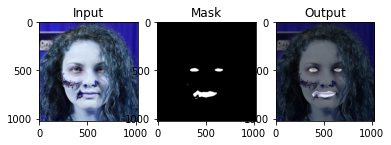

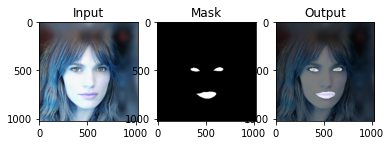

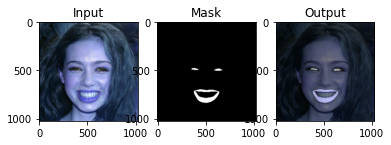

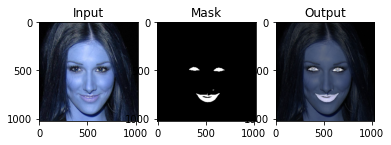

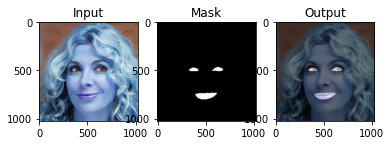

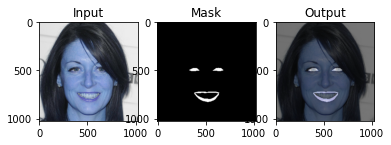

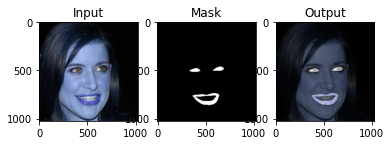

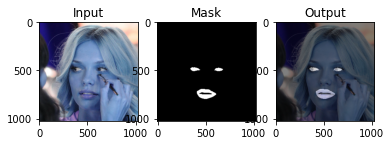

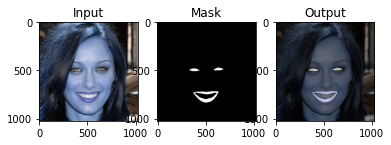

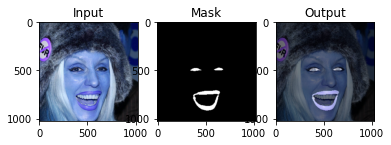

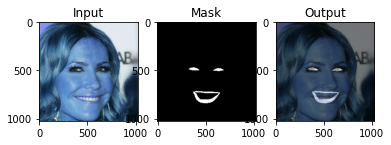

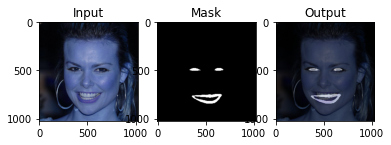

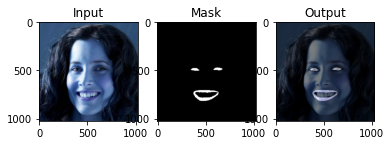

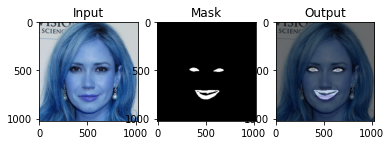

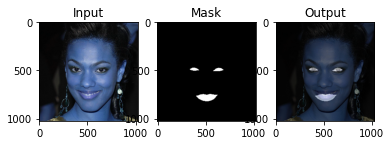

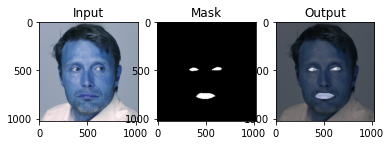

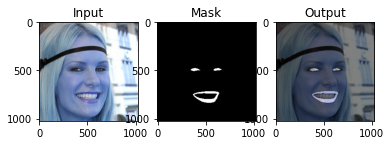

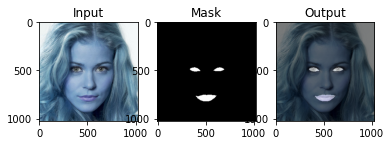

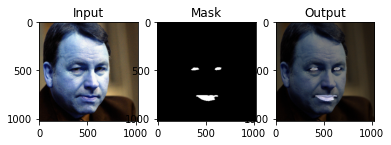

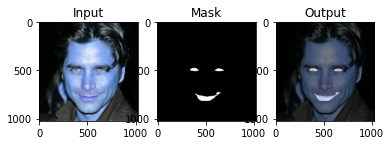

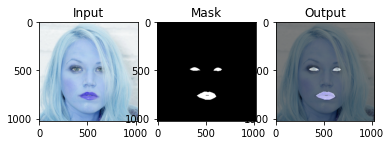

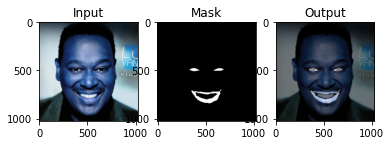

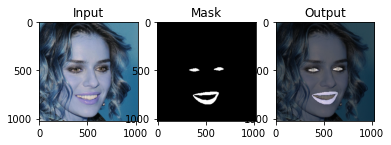

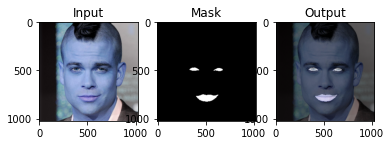

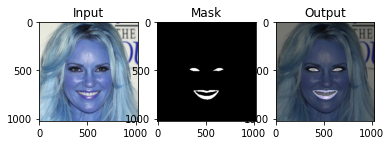

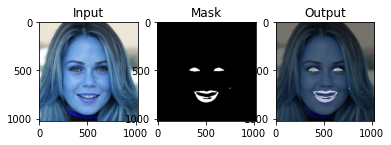

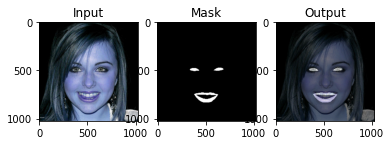

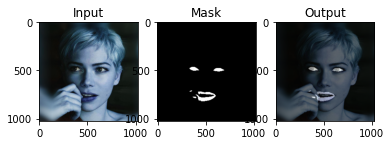

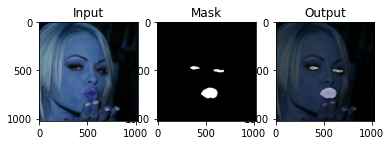

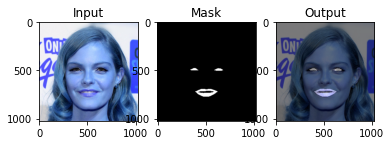

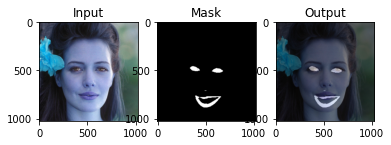

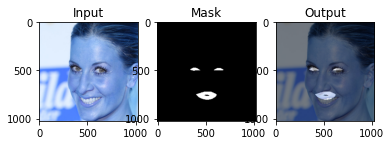

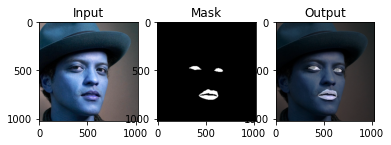

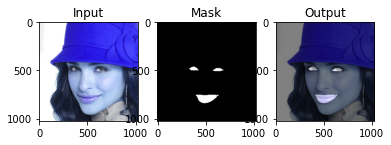

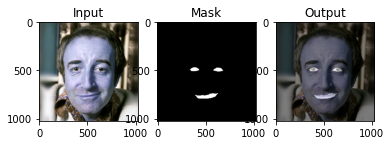

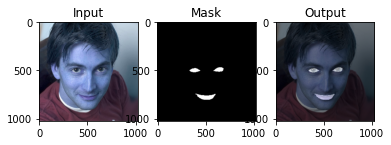

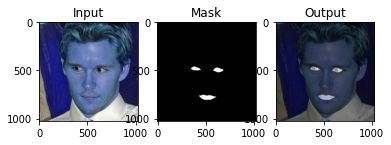

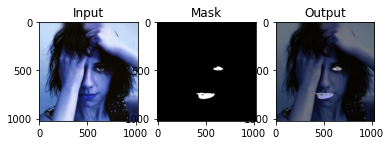

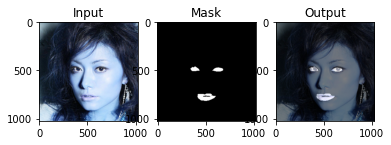

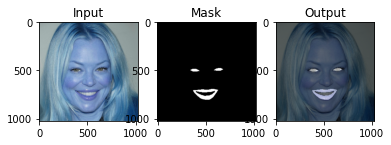

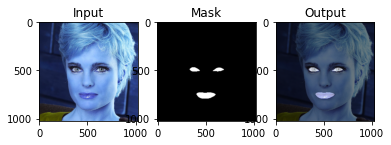

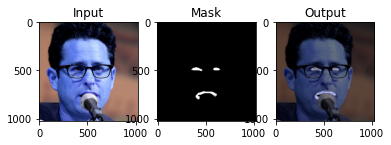

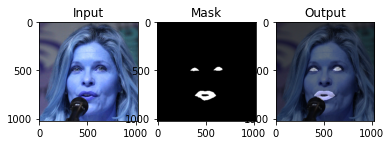

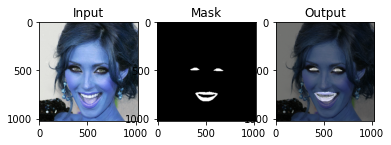

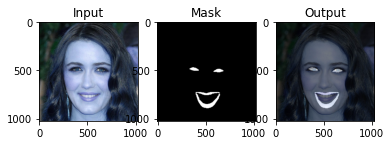

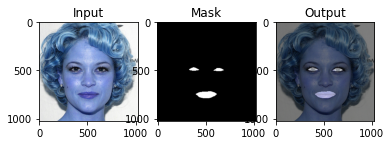

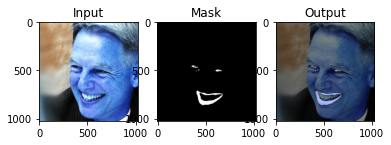

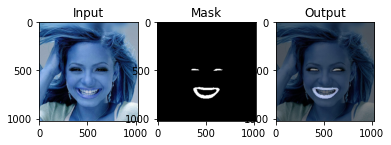

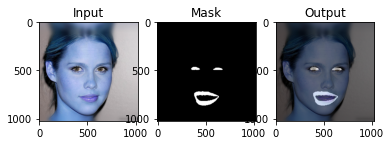

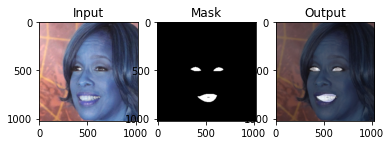

In [ ]:
import matplotlib.pyplot as plt #for plotting purposes

#initialize input and mask images' path for test data
test_input_path=base_path+"/CelebA-HQ-img2ktest/" 
predicted_mask_path=base_path+"/results/"

for i in range(imgs.shape[0]): #for every image
    img=cv2.imread(test_input_path+str(2010+i)+'.jpg') #fetch test image
    mask=cv2.imread(predicted_mask_path+str(i)+'.jpg') #fetch the predicted mask
    output=cv2.addWeighted(src1=img, alpha=0.5, src2=mask, beta=0.5 , gamma=0.0) #overlay the mask upon the image
    fig=plt.figure() #add figure space
    a = fig.add_subplot(1,3,1) #break into 3 subplots and insert the test image in first subplot
    imgplot = plt.imshow(img)
    a.set_title('Input') #set title
    a = fig.add_subplot(1,3,2) #insert the predicted mask in the second subplot 
    imgplot = plt.imshow(mask)
    a.set_title('Mask') #title mask
    a = fig.add_subplot(1,3,3) #insert the overlay output on the third subplot
    imgplot = plt.imshow(output) 
    a.set_title('Output') #title it output

STEP 007: Inferences

1. Upon running for 50 epochs, both the training as well as validation data had accuracy of 0.99 and loss around 0.01. Since validation data loss is close to training data loss, we can infer the model is NOT overfitting. Also the model was incorporated with early atopping and hence upon no improvement, around the 46th epoch, the training came to a halt.


2. However, upon visualising our outputs, we can still see the masks not accurate (not that bang on) for all the images, indicating that we can still converge to better solutions, upon playing with epoch size and batch size..

3. Also data augmentation can also help in incorporating scale and positional invariances. Especially certain masks predicted tend to be a mirror image of the actual mask. Hence, data augmentation could result in better stability. However, in the interest of time, currently keeping data augmentation under future action items, since a decent accuracy is already obtained.

4. And, we have only used 2k of the data, where in we have 30k datapoints. hence upon using more data for training, we can come out for more accurate predictions. 

5. Usage of adam optimizer helped in quicker convergence right from epoch 1.